In [1]:
import pandas as pd
import numpy as np
from datetime import date
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import sqrt

from lifelines import KaplanMeierFitter
#from lifelines.plotting import add_at_risk_counts
#this version of lifelines has some formatting issues with adding "At Risk Counts". 
#This was manually patched and imported below in the Survival Analysis section.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Inclusion Criteria

Creating the final sample of due trials for 16 September 2019. 

Based on our raw data, the entire ClinicalTrials.gov database contained 316,342 trials on this date.

The Sankey diagram is included in the Appendix of the publication.

In [3]:
inc = pd.read_csv('Processed CSVs/applicable_trials_2019-09-16.csv')
inc['due_date'] = pd.to_datetime(inc.due_date)

all_ctgov = 316342 #taken from raw data
all_applicable = len(inc)
due = len(inc[inc.results_due==1])
not_due = len(inc[inc.due_date >= pd.Timestamp(2019,9,16)])
due_cert = len(inc[(inc.due_date < pd.Timestamp(2019,9,16)) & (inc.has_certificate == 1)])

In [4]:
inc_crit = """
The ClinicalTrials.gov database contained {} trials in total.
We excluded {} trials as they were neither an ACT nor a pACT.
We excluded a further {} trials as they were not yet due.
{} trials were excluded as they were due, but had received a Certificate Of Delay. 
{} trials were therefore identified as due to report results to ClinicalTrial.gov under the FDAAA 2007.
""".format(all_ctgov, all_ctgov-all_applicable, not_due, due_cert, due)
print(inc_crit)


The ClinicalTrials.gov database contained 316342 trials in total.
We excluded 294817 trials as they were neither an ACT nor a pACT.
We excluded a further 16650 trials as they were not yet due.
666 trials were excluded as they were due, but had received a Certificate Of Delay. 
4209 trials were therefore identified as due to report results to ClinicalTrial.gov under the FDAAA 2007.



In [23]:
import plotly.graph_objs as go

fig = go.Figure(data=[go.Sankey(
    arrangement = 'freeform',
    node = dict(
      pad = 15,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = ["All CT.gov: {}".format(all_ctgov), "Not Applicable: {}".format(all_ctgov-all_applicable),
               "Applicable: {}".format(all_applicable), "Not Due: {}".format(not_due), 
               "Received Certificate: {}".format(due_cert), "Due: {}".format(due), ""],
      color = "#1f77b4",
        x = [0, .799 , .5, .798, .798, .798],
        y = [0, .3, .9, .8, .9, .99]
    ),
    link = dict(
      source = [0, 0, 2, 2, 2], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [1, 2, 3, 4, 5],
      value = [all_ctgov, all_applicable, not_due, due_cert, due],
        color = ['#ADE1CA', 'lightblue', 'grey', 'grey', '#EA573A']
  ))])

#fig
fig.write_image("sankey.svg")

# Trends

This code creates graphs that track the overall reporting of trial over time. We can create a snapshot of FDAAA compliance for any date in our ClinicalTrials.gov archive (dating to February 2018). See the notebook or script "Processing Raw FDAAA Data" for the code to generate a processed file for any archived csv with 1 trial in JSON format per row. These raw files are large, so this is run in seperate code and CSVs of the processed data are saved for data sharing and quicker future data handling/analysis.

Processed data is available both in this directory. Copies of all raw and processed data is available at https://osf.io/x8nbv/

Once we have a processed dataset for each date in our analysis with only appliable trials, we can measure how many are due, if/when they reported, how late they were on any given date, etc.

This creates Figure 2 in the paper

In [6]:
#This cell pulls out counts for each month based on the processed data.

#Lists for statistics of interest
reported_by_month_all = []
reported_by_month_on_time = []
due_by_month  = []
reporting_prcts = []
overdue_by_month = []

#QA data manually scraped for due trials before this data was included in the ClinicalTrials.gov XML in May 2018.
qa = pd.read_csv('qa.csv')
qa.submitted_to_regulator = pd.to_datetime(qa['submitted_to_regulator'])
grouped = qa.groupby(['registry_id']).min()

#Dates of scrapes used, on or as close to mid-month available. Edit this as appropriate for dates of interest
scrape_dates = [date(2018,3,15), date(2018,4,16), date(2018,5,15), date(2018,6,15), date(2018,7,16), date(2018,8,13), 
                date(2018,9,14), date(2018,10,15), date(2018,11,15), date(2018,12,14), date(2019,1,15),
                date(2019,2,15), date(2019,3,15), date(2019,4,15), date(2019,5,15), date(2019,6,13), date(2019,7,15),
                date(2019,8,15), date(2019,9,16)]

#Location of previously processed CSVs.
path = 'Processed CSVs' #processed files should be here or edit as appropriate to point to their local location
files = os.listdir(path)
files.sort()

#removing hidden file when analysis is performed on a Mac
if '.DS_Store' in files:
    files.remove('.DS_Store')

#Importing custom function to get summary data
from programs.summary_data import get_summary_data

#This loops through all the processed files, and produces the relevant statistics of interest for each date. 
#Data from before the availability of QA details in the XML are handled using 'qa' data we manually maintained through scrapes
#Data is processed via the `get_summary_data` function imported above
for file, scrape_date in zip(files, scrape_dates):
    df = pd.read_csv(os.path.join(path, file), low_memory=False)
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['results_first_submitted_date'] = pd.to_datetime(df['results_first_submitted_date'])
    df['first_results_submission_any'] = pd.to_datetime(df['first_results_submission_any'])
    numerator, denominator, number_on_time = get_summary_data(df,scrape_date,grouped)
    reported_by_month_all.append(numerator)
    due_by_month.append(denominator)
    overdue_by_month.append(denominator - numerator)
    reporting_prcts.append(round((numerator/denominator)*100,2))
    reported_by_month_on_time.append(number_on_time)

#calculates percents for reporting on-time.
prct_on_time = []
for a, b, in zip(reported_by_month_on_time, due_by_month):
    prct_on_time.append(round((a/b)*100,2))

In [7]:
#Function to get CIs for reporting graph.

def ci_calc(nums, denoms):
    cis = []
    z = 1.96
    for n,d in zip(nums,denoms):
        p = n/d
        se = (p*(1-p))/d
        ci = z * sqrt(se)
        cis.append(ci*100)
    return cis

line_errors = ci_calc(reported_by_month_all, due_by_month)

line_errors_on_time = ci_calc(reported_by_month_on_time, due_by_month)

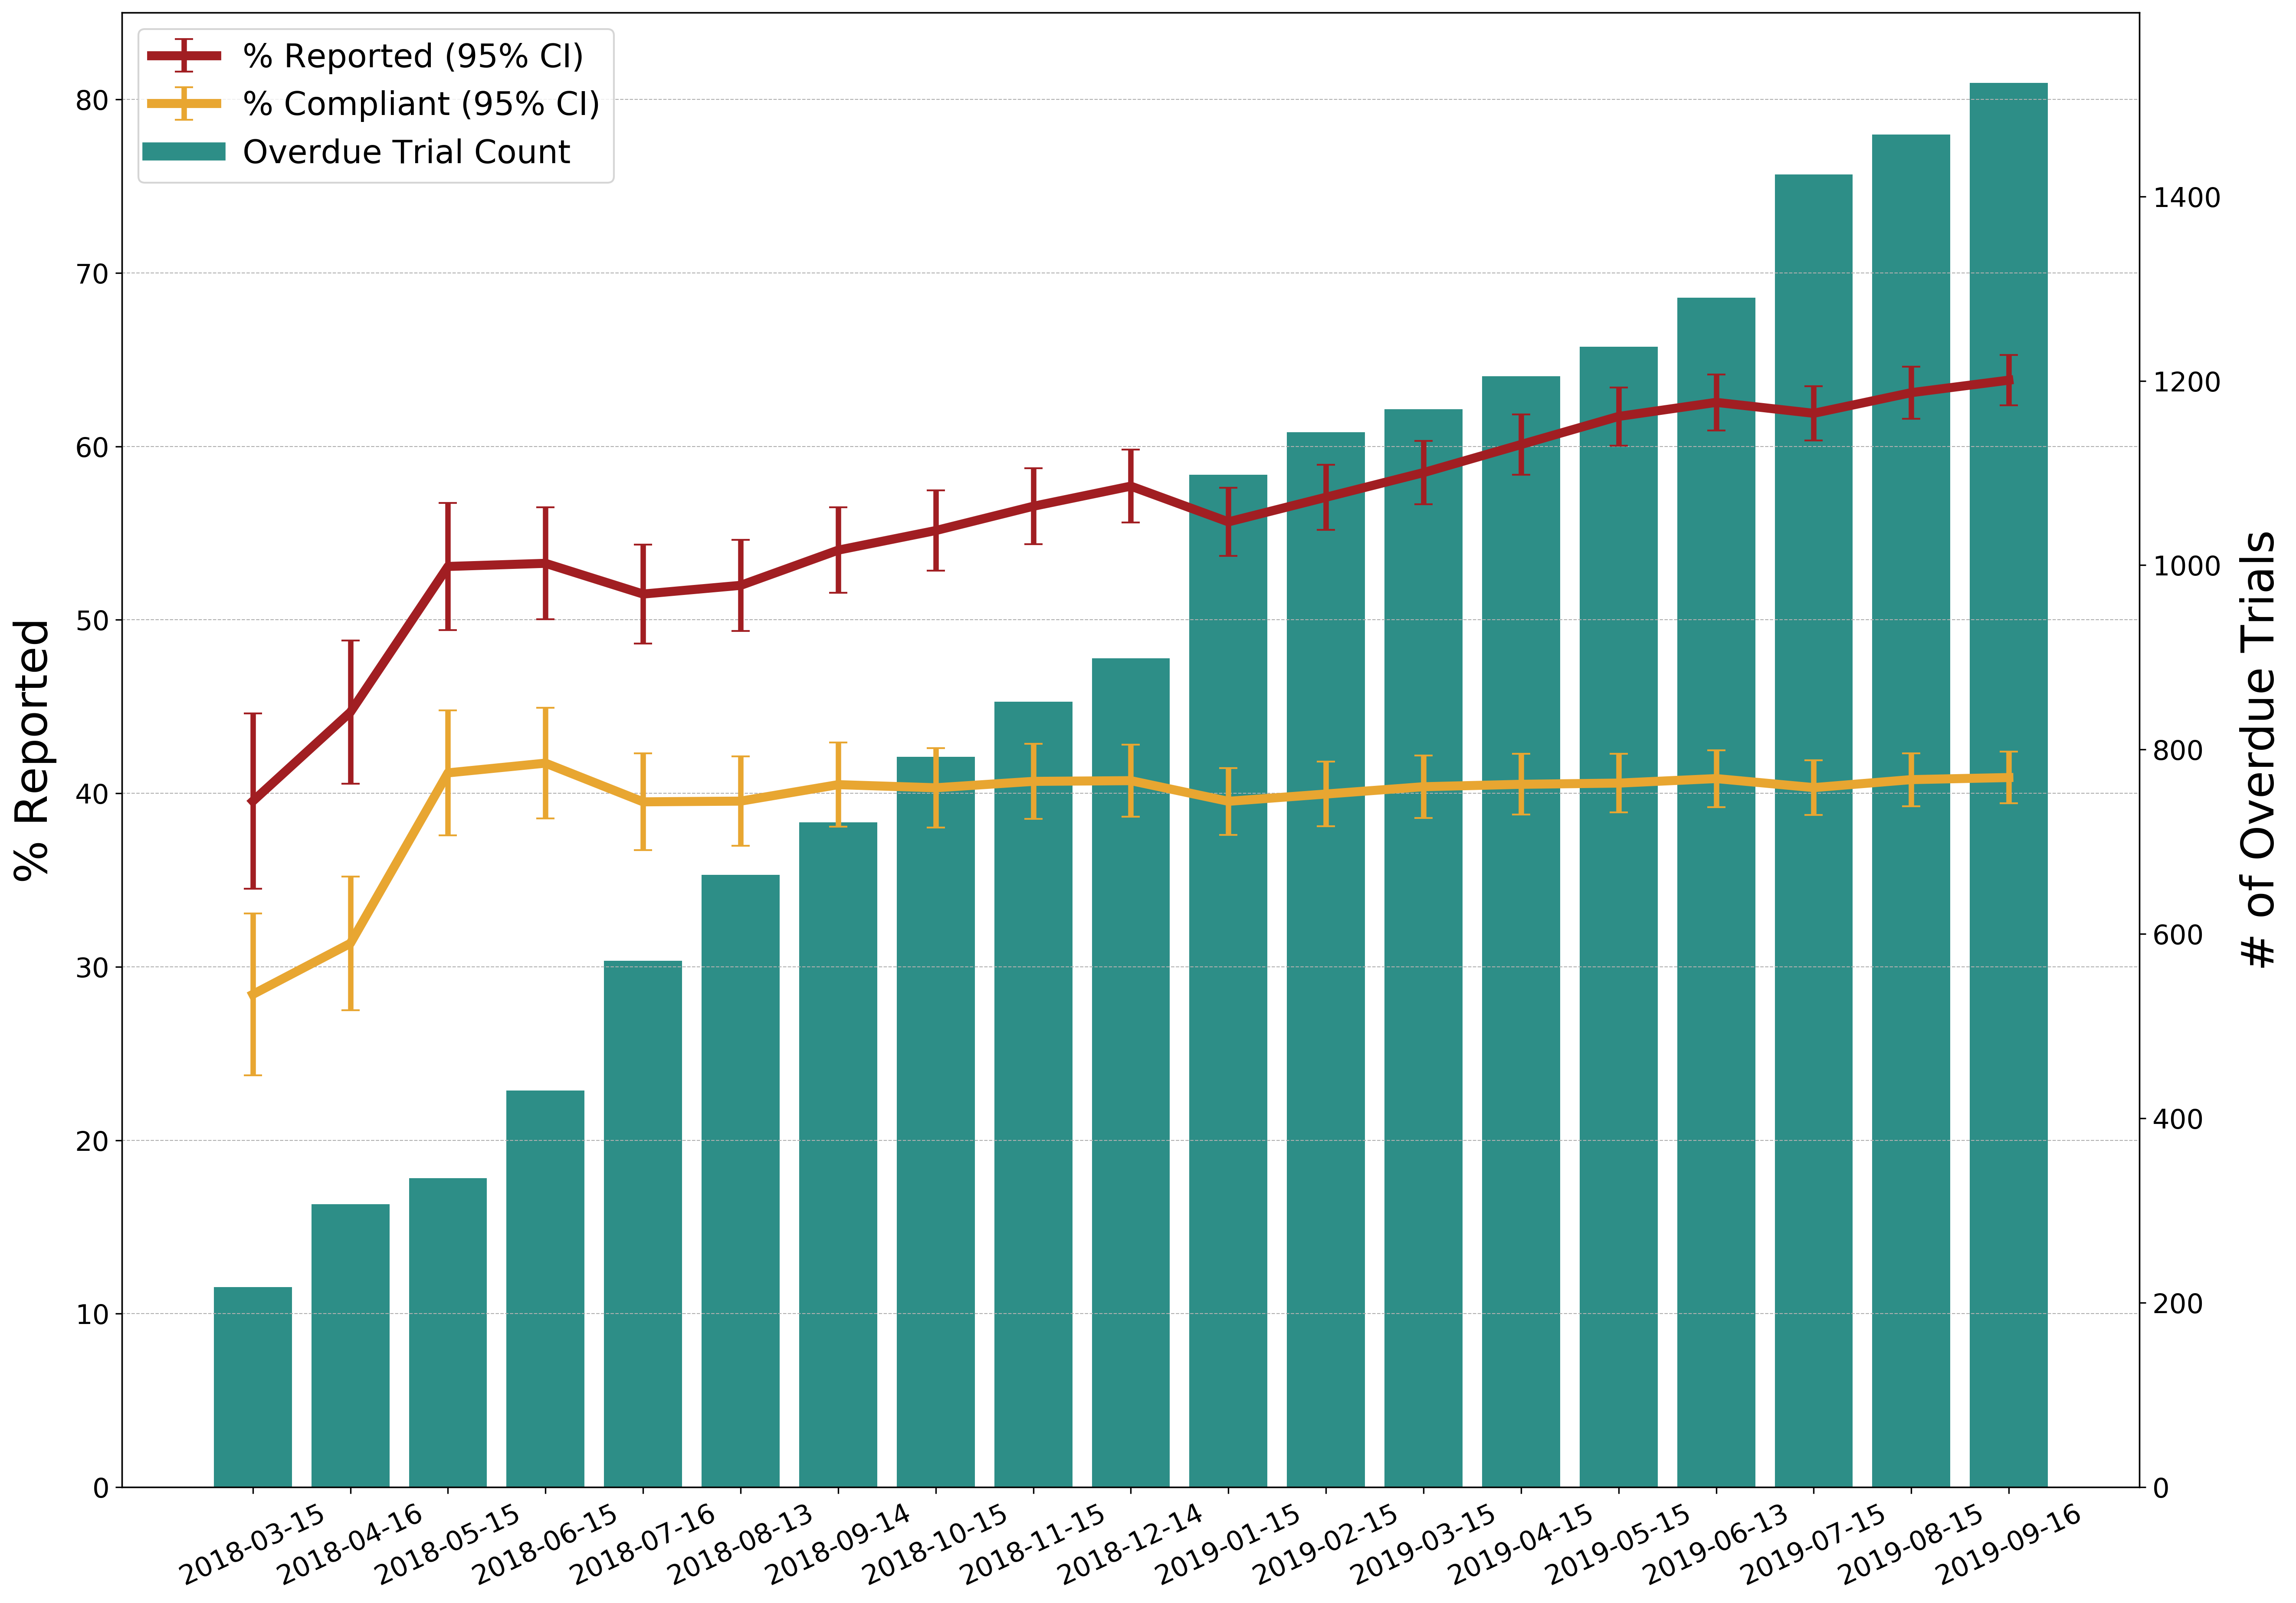

In [55]:
#creates graph of reporting, and reporting in compliance percentage as a line over a bar graph of overdue trials by month

fig, ax = plt.subplots(figsize=(20,15), dpi = 300)
index = np.arange(len(scrape_dates))
l1 = plt.errorbar(index,reporting_prcts, yerr=line_errors, elinewidth = 3, capsize=5, c = '#A11E22', lw=5)
l2 = plt.errorbar(index,prct_on_time, yerr=line_errors_on_time, elinewidth = 3, capsize=5, c = '#E8A631', lw=5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('% Reported', fontsize=25, labelpad=10)
plt.xticks(rotation=25)
#plt.title("Reporting Percentage and Overdue Trials By Month", pad = 20, fontsize = 30)
l3 = Line2D([0], [0], color='#2D8E87', ls='-', lw=10)
plt.legend((l1, l2, l3), ('% Reported (95% CI)', '% Compliant (95% CI)', 'Overdue Trial Count'), loc=2, fontsize=18)
ax.set_ylim([0,85])

ax2 = plt.twinx()
ax2.set_axisbelow(True)
ax.yaxis.grid(linestyle='--', linewidth=.5, zorder=ax.get_zorder()-10)
ax2.bar(index, overdue_by_month, capsize=5, tick_label = scrape_dates, color='#2D8E87')
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('# of Overdue Trials', fontsize=25, labelpad=10)

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.savefig('figure_2.svg', dpi=300)

# Ranked Sponsors

Ranking of all sponsors reporting for covered trials for the most recent data included.

The creates Table 4 in the paper as well as the larger appendix

In [45]:
df = pd.read_csv('Processed CSVs/applicable_trials_2019-09-16.csv')


#Pulling only the data we need with and indicator for "Reported Late"
cols = ['nct_id', 'results_due', 'has_results', 'pending_results', 'due_date', 'available_completion_date', 
        'first_results_submission_any', 'sponsor']

rankings_df = df[cols][df.results_due == 1].reset_index(drop=True)
rankings_df['reported_late'] = np.where(((rankings_df.due_date < rankings_df.first_results_submission_any) & 
                                         rankings_df.first_results_submission_any.notnull()), 1, 0)

In [50]:
#Group by sponsor and create proportions.

grouped_spon = rankings_df.groupby(by='sponsor').sum()
grouped_spon['reported'] = grouped_spon.has_results + grouped_spon.pending_results
grouped_spon['reporting_prct'] = round((grouped_spon.reported / grouped_spon.results_due) * 100,1)
grouped_spon['on_time_reporting_prct'] = round(((grouped_spon.reported - grouped_spon.reported_late) / grouped_spon.results_due) * 100,1)
grouped_spon['compliant'] = grouped_spon.reported - grouped_spon.reported_late

#Sort by the number of results due
grouped_spon.sort_values(by='results_due', ascending=False, inplace=True)

In [51]:
paper_table = grouped_spon[['results_due', 'reported', 'reporting_prct', 'compliant', 'on_time_reporting_prct']]

In [52]:
#Get all sponsors with >=30 trials due

large_sponsors = paper_table[paper_table.results_due >= 30]
large_sponsors.head()

,results_due,reported,reporting_prct,compliant,on_time_reporting_prct
sponsor,,,,,
M.D. Anderson Cancer Center,85,71,83.5,29,34.1
National Cancer Institute (NCI),79,65,82.3,24,30.4
Massachusetts General Hospital,58,46,79.3,32,55.2
Mayo Clinic,47,45,95.7,10,21.3
Novartis Pharmaceuticals,46,46,100.0,46,100.0


In [53]:
#Get all sponsors with >= 10 trials due

sponsors = paper_table[paper_table.results_due >= 10]
sponsors.head()

,results_due,reported,reporting_prct,compliant,on_time_reporting_prct
sponsor,,,,,
M.D. Anderson Cancer Center,85,71,83.5,29,34.1
National Cancer Institute (NCI),79,65,82.3,24,30.4
Massachusetts General Hospital,58,46,79.3,32,55.2
Mayo Clinic,47,45,95.7,10,21.3
Novartis Pharmaceuticals,46,46,100.0,46,100.0


# Reporting Survivorship

Developing Kaplan-Meier curves for analysis of how long it takes trials to report once they become due.

This creates Figure 1(a, b, & c) in the paper.

In [3]:
#Data Handling and Processing

#reading in the processed data for just 16 September 2019
df = pd.read_csv('Processed CSVs/applicable_trials_2019-09-16.csv')

#Taking only columns needed
reporting_surv = df[['nct_id', 'results_due', 'has_results', 'pending_results', 'due_date', 'available_completion_date', 
                'first_results_submission_any', 'sponsor_type']][df.results_due == 1].reset_index(drop=True)

#Creating columns necessary for analysis
#Denotes if a trial has reported whether QC has been completed or not
reporting_surv['reported'] = np.where(((reporting_surv.has_results==1) | (reporting_surv.pending_results ==1)), 1, 0)
#Static column for the fixed date the data was pulled
reporting_surv['scrape_date'] = pd.datetime(2019,9,16)

#Getting dates into date format
reporting_surv['due_date'] = pd.to_datetime(reporting_surv['due_date'], format = '%Y-%m-%d')
reporting_surv['available_completion_date'] = pd.to_datetime(reporting_surv['available_completion_date'], format = '%Y-%m-%d')
reporting_surv['first_results_submission_any'] = pd.to_datetime(reporting_surv['first_results_submission_any'], format = '%Y-%m-%d')

In [4]:
#data for if you want to do survivorship analysis from when trials become due
#this is used for figure c
reporting_surv['days_late'] = (reporting_surv.first_results_submission_any - reporting_surv.due_date) / pd.Timedelta('1 day')
reporting_surv['censored_due'] = (reporting_surv.scrape_date - reporting_surv.due_date) / pd.Timedelta('1 day')
reporting_surv.loc[reporting_surv['reported'] == 1, 'censored_due'] = None
reporting_surv['duration_due'] = np.where(reporting_surv.censored_due.notnull(), reporting_surv.censored_due, reporting_surv.days_late)
reporting_surv['duration_due'] = np.where(reporting_surv['duration_due'] < 0, 0, reporting_surv['duration_due'])

#data for if you want to do survivorship analysis from when the trial reached primary completion
#This is used for figures a and b
reporting_surv['days_from_completion'] = (reporting_surv.first_results_submission_any - reporting_surv.available_completion_date) / pd.Timedelta('1 day')
reporting_surv['censored_completion'] = (reporting_surv.scrape_date - reporting_surv.available_completion_date) / pd.Timedelta('1 day')
reporting_surv.loc[reporting_surv['reported'] == 1, 'censored_completion'] = None
reporting_surv['duration_completion'] = np.where(reporting_surv.censored_completion.notnull(), reporting_surv.censored_completion, reporting_surv.days_from_completion)
reporting_surv['duration_completion'] = np.where(reporting_surv['duration_completion'] < 0, 0, reporting_surv['duration_completion'])

#For both of these examples, a trial that reports before relevant date (due or completion)
#is defaulted to being reported at 0 days.

#Looking at only trials that become overdue
reporting_surv_due = reporting_surv[(reporting_surv.due_date < reporting_surv.first_results_submission_any) | 
                                    (reporting_surv.first_results_submission_any.isnull())]

In [5]:
#Checking the number of trials that first reported results prior to primary completion date as requested during peer review.

print(len(reporting_surv))
print(len(reporting_surv[reporting_surv.first_results_submission_any < reporting_surv.available_completion_date]))
(27/4209) * 100

4209
27


0.6414825374198148

Median time to report: 424.0 days


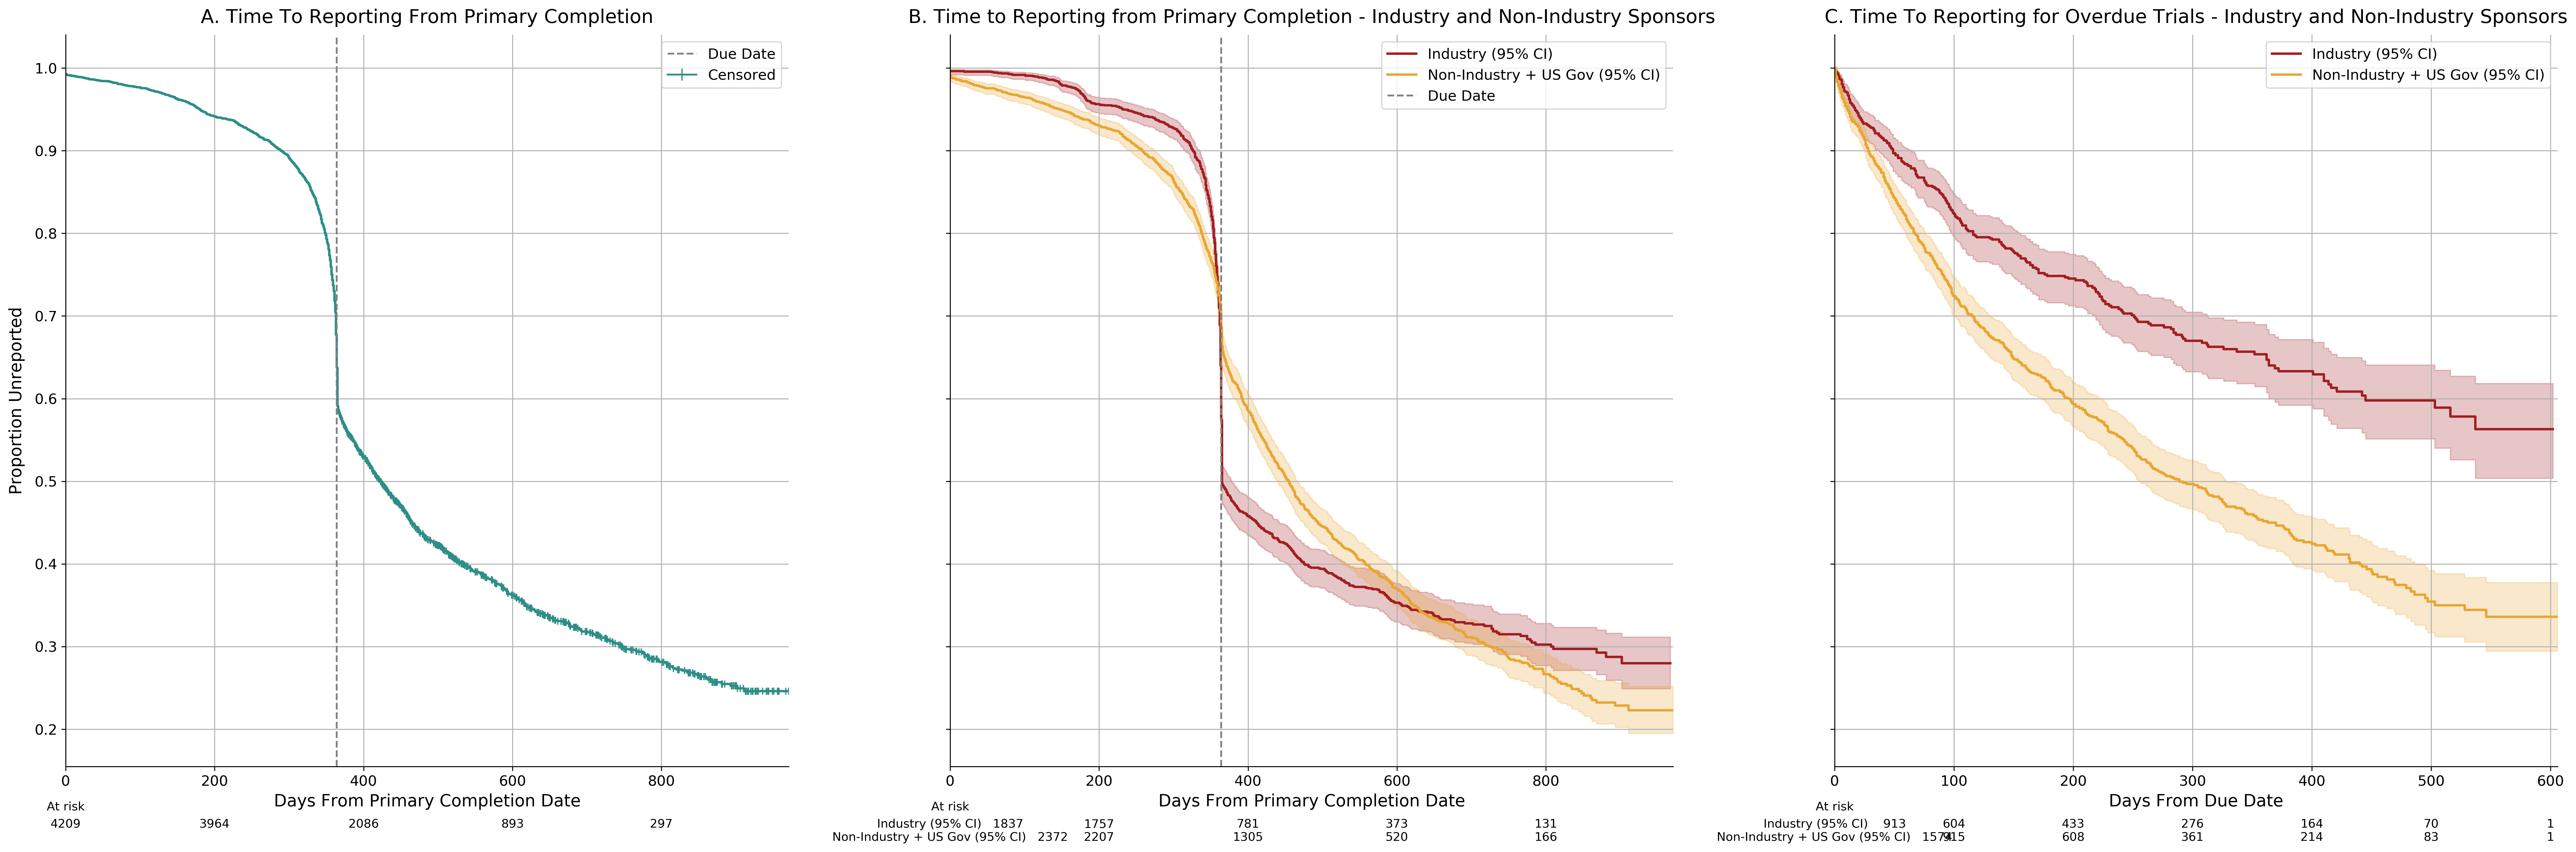

In [11]:
#This combines all the relevant analyses into 1 figure. Each of these figures is also reproduced as a stand-alone figure below

#Patches formatting issues for the At Risk Counts function in Lifelines
from lifelines_fix import add_at_risk_counts

figsize = (30,10)

yticks = list(np.arange(0,1.1,.1))
fig = plt.figure(dpi=300)

#overall survival from primary completion
ax1 = plt.subplot(131)
kmf_overall = KaplanMeierFitter().fit(reporting_surv.duration_completion, reporting_surv["reported"])
kmf_overall.plot(ci_show=False, show_censors=True, censor_styles={'ms':6, 'marker':'|'}, yticks=yticks, 
                 figsize=figsize, grid=True, legend=False, ax=ax1, lw=2, c = '#2D8E87')
ax1.axvline(x=364, color='grey', ls='--')
plt.title("A. Time To Reporting From Primary Completion", pad=10, fontsize=16)
plt.ylabel('Proportion Unreported', labelpad=8, fontsize=14)
plt.xlabel('Days From Primary Completion Date', labelpad=4, fontsize=14)

add_at_risk_counts(10, kmf_overall, position=-.1, labels=None)
ax1.tick_params(labelsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

leg_1 = Line2D([0], [0], color='grey', ls='--')
leg_2 = Line2D([0], [0], color='#2D8E87', marker='|', ms=10)
leg = [leg_1, leg_2]
leg_lab = ['Due Date', 'Censored']
plt.legend(leg, leg_lab, fontsize=12)

#Ind/Non Ind from Primary Completion
ax2 = plt.subplot(132, sharey = ax1)
kmf_ind = KaplanMeierFitter().fit(reporting_surv.duration_completion[reporting_surv.sponsor_type == 'Industry'], 
                                  reporting_surv["reported"][reporting_surv.sponsor_type == 'Industry'], 
                                  label = 'Industry (95% CI)')
kmf_ind.plot(ci_show=True, yticks=yticks, figsize=figsize, grid=True, lw = 2, ax=ax2, c = '#A11E22')

kmf_non_ind = KaplanMeierFitter().fit(reporting_surv.duration_completion[reporting_surv.sponsor_type != 'Industry'], 
                                      reporting_surv["reported"][reporting_surv.sponsor_type != 'Industry'], 
                                      label = 'Non-Industry + US Gov (95% CI)')
kmf_non_ind.plot(ci_show=True, yticks=yticks, figsize=figsize, grid=True, ax=ax2, lw = 2, c = '#E8A631')

plt.title('B. Time to Reporting from Primary Completion - Industry and Non-Industry Sponsors', pad=10, fontsize = 16)
plt.xlabel('Days From Primary Completion Date', labelpad=4, fontsize=14)

ax2.axvline(x=364, color='grey', ls='--', label = 'Due Date')
ax2.legend(fontsize = 10)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(labelsize=12)

plt.legend(fontsize=12)

add_at_risk_counts(10, kmf_ind, kmf_non_ind, position=-.1)

#Ind/Non Ind from Due
ax3=plt.subplot(133, sharey = ax1)
kmf_ind_due = KaplanMeierFitter().fit(reporting_surv_due.duration_due[reporting_surv_due.sponsor_type == 'Industry'], 
        reporting_surv_due["reported"][reporting_surv_due.sponsor_type == 'Industry'], label = 'Industry (95% CI)')
kmf_ind_due.plot(ci_show=True, figsize=figsize, grid=True, lw = 2, ax=ax3, yticks=yticks, c = '#A11E22')

kmf_non_ind_due = KaplanMeierFitter().fit(reporting_surv_due.duration_due[reporting_surv_due.sponsor_type != 'Industry'], 
        reporting_surv_due["reported"][reporting_surv_due.sponsor_type != 'Industry'], label = 'Non-Industry + US Gov (95% CI)')
kmf_non_ind_due.plot(ci_show=True, figsize=figsize, grid=True, lw = 2, ax=ax3, yticks=yticks, c = '#E8A631')

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(labelsize=12)

plt.title("C. Time To Reporting for Overdue Trials - Industry and Non-Industry Sponsors", pad=10, fontsize = 16)
plt.xlabel('Days From Due Date', labelpad=4, fontsize=14)
ax3.legend(fontsize = 12)

add_at_risk_counts(10, kmf_ind_due, kmf_non_ind_due, position=-.1)
#plt.savefig('figure_1.svg', dpi=300)

print('Median time to report: {} days'.format(kmf_overall.median_survival_time_))

Median time to report: 424.0 days


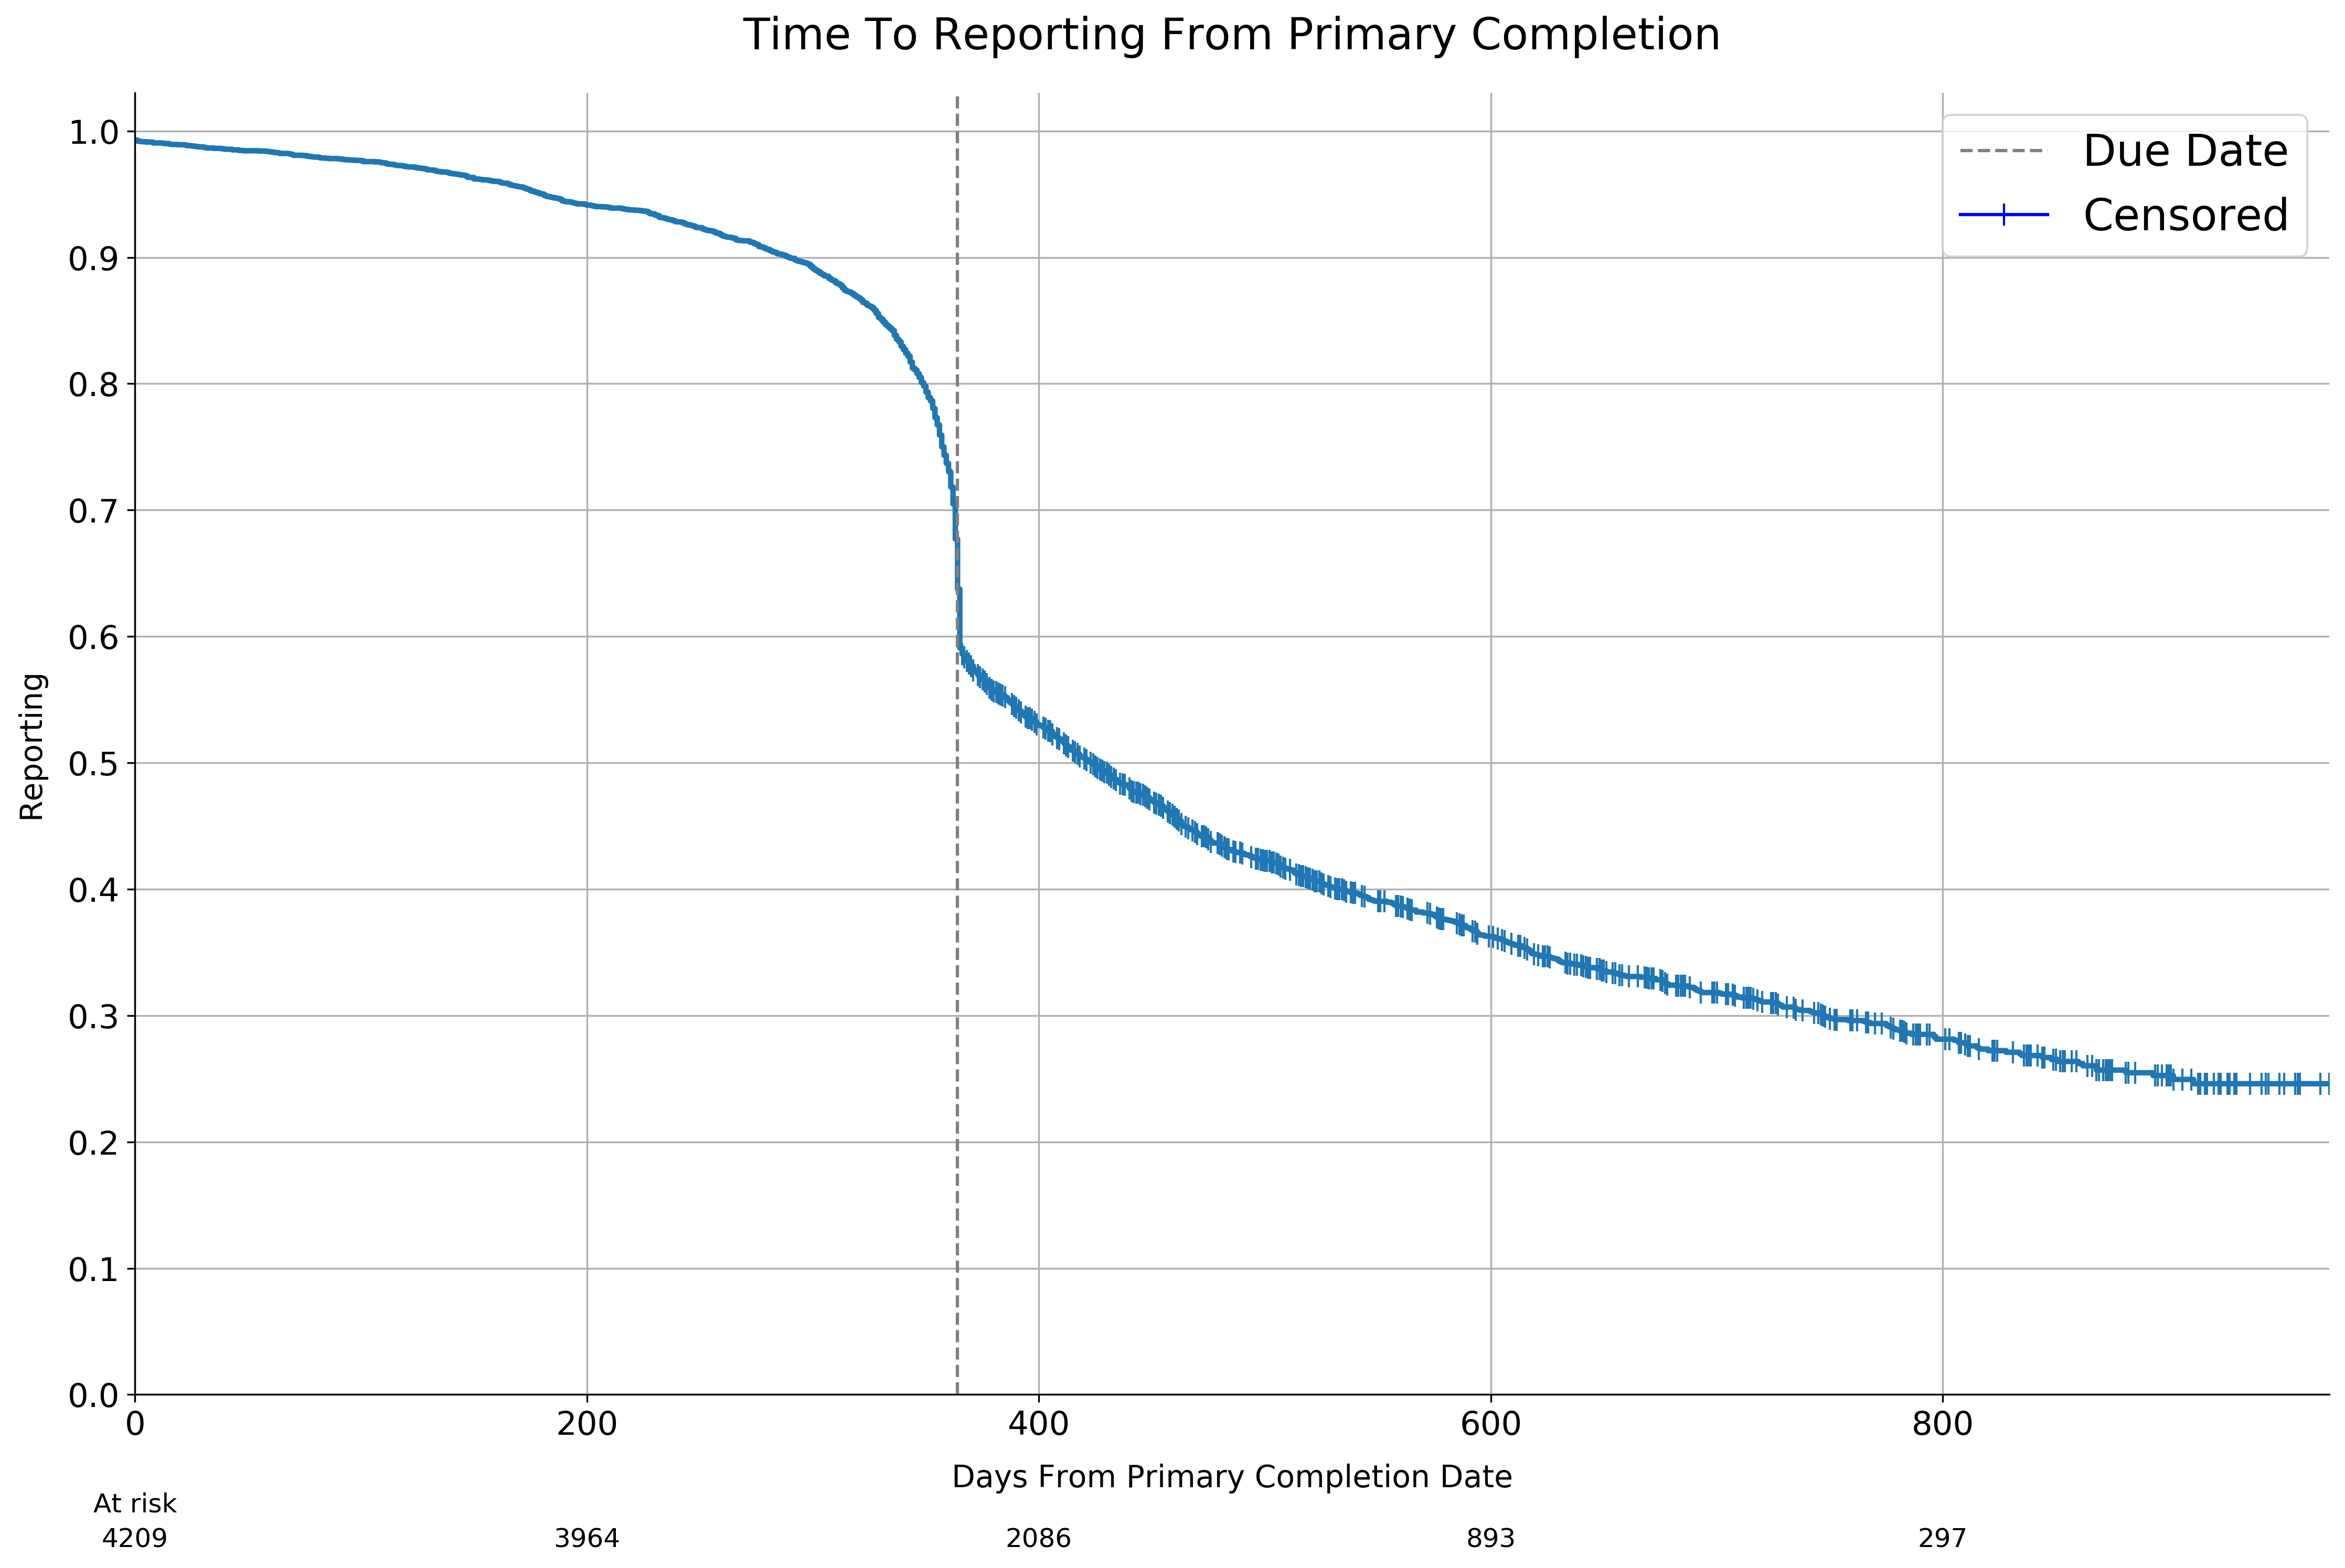

In [29]:
#KM Curve for reporting from primary completion date. Dotted line represents the "due date" of 1 year after completion
yticks = list(np.arange(0,1.1,.1))
fig = plt.figure(dpi=300)
ax = plt.subplot()

kmf_overall = KaplanMeierFitter()
kmf_overall.fit(reporting_surv.duration_completion, reporting_surv["reported"])
print('Median time to report: {} days'.format(kmf_overall.median_survival_time_))
#ax = kmf_overall.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax =  kmf_overall.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)


ax.axvline(x=364, color='grey', ls='--')
plt.title("Time To Reporting From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days From Primary Completion Date', labelpad=10, fontsize=14)

ax.tick_params(labelsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
add_at_risk_counts(12, kmf_overall, labels=None)

leg_1 = Line2D([0], [0], color='grey', ls='--')
leg_2 = Line2D([0], [0], color='blue', marker='|', ms=10)
leg = [leg_1, leg_2]
leg_lab = ['Due Date', 'Censored']

plt.legend(leg, leg_lab, fontsize=20)
#plt.savefig('survival_with_censor.png')

In [18]:
#The proportion reported any day can be checked by running this code and editing the value in loc[]:
print(kmf_overall.survival_function_.loc[796]['KM_estimate'])
print(kmf_overall.survival_function_.loc[815]['KM_estimate'])

#If you are interested in the full data produced by the survival function you can view it here:
surv_func = kmf_overall.survival_function_
surv_func.head()

0.28318862644314713
0.274712213803258


,KM_estimate
timeline,
0.0,0.992872
1.0,0.991922
2.0,0.991684
3.0,0.991447
5.0,0.991209


Median time to report for Industry: 365.0 days
Median time to report for Non-industry: 455.0 days


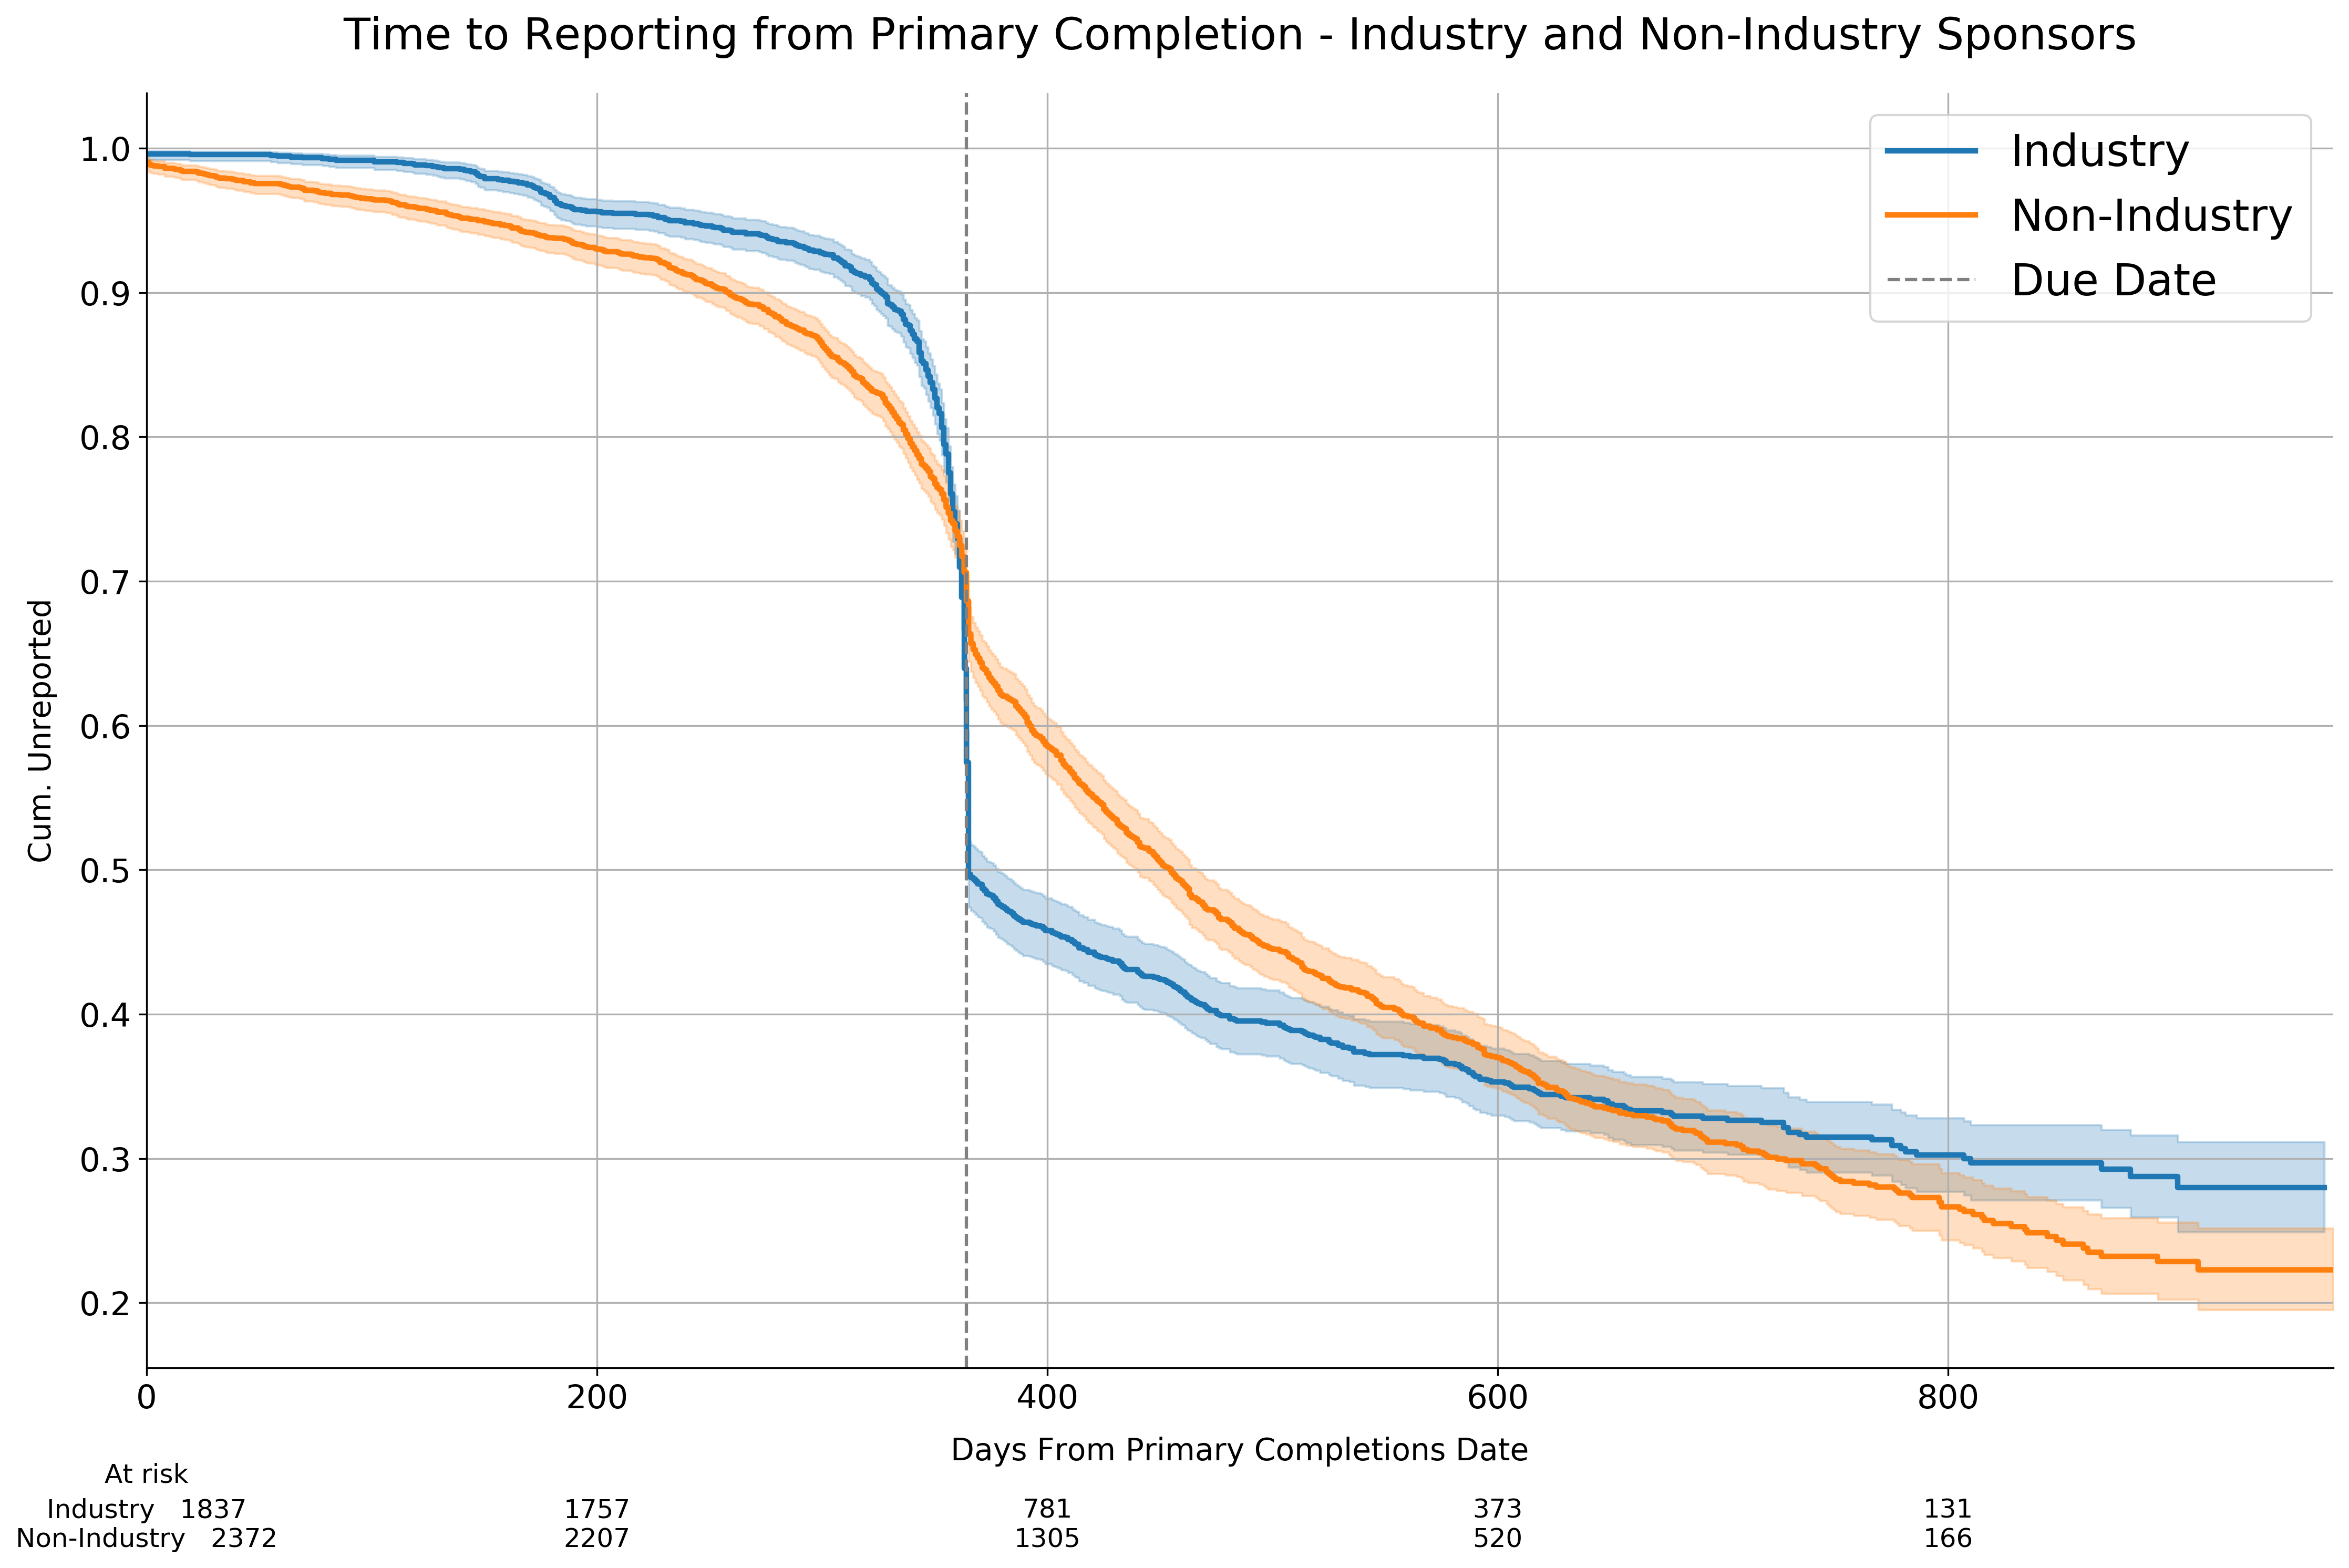

In [22]:
#KM Curve for reporting from primary completion date for Industry and Non-Industry. 
#Dotted line represents the "due date" of 1 year after completion

yticks = list(np.arange(0,1.1,.1))
fig = plt.figure(dpi=300)
ax = plt.subplot()

kmf_ind = KaplanMeierFitter()
kmf_ind.fit(reporting_surv.duration_completion[reporting_surv.sponsor_type == 'Industry'], reporting_surv["reported"][reporting_surv.sponsor_type == 'Industry'], label = 'Industry')
print('Median time to report for Industry: {} days'.format(kmf_ind.median_survival_time_))
ax = kmf_ind.plot(ci_show=True, yticks=yticks, figsize=(15,10), grid=True, lw = 2.5, ax=ax)


kmf_non_ind = KaplanMeierFitter()
kmf_non_ind.fit(reporting_surv.duration_completion[reporting_surv.sponsor_type != 'Industry'], reporting_surv["reported"][reporting_surv.sponsor_type != 'Industry'], label = 'Non-Industry')
print('Median time to report for Non-industry: {} days'.format(kmf_non_ind.median_survival_time_))
ax = kmf_non_ind.plot(ci_show=True, yticks=yticks, figsize=(15,10), grid=True, ax=ax, lw = 2.5)

plt.ylabel('Cum. Unreported', labelpad=10, fontsize=14)
plt.xlabel('Days From Primary Completions Date', labelpad=10, fontsize=14)
plt.title('Time to Reporting from Primary Completion - Industry and Non-Industry Sponsors', pad=20, fontsize = 20)

ax.axvline(x=364, color='grey', ls='--', label = 'Due Date')
ax.legend(fontsize = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=15)

plt.legend(fontsize=20)

add_at_risk_counts(12, kmf_ind, kmf_non_ind)

Median time to report for Industry: inf days
Median time to report for Industry: 289.0 days


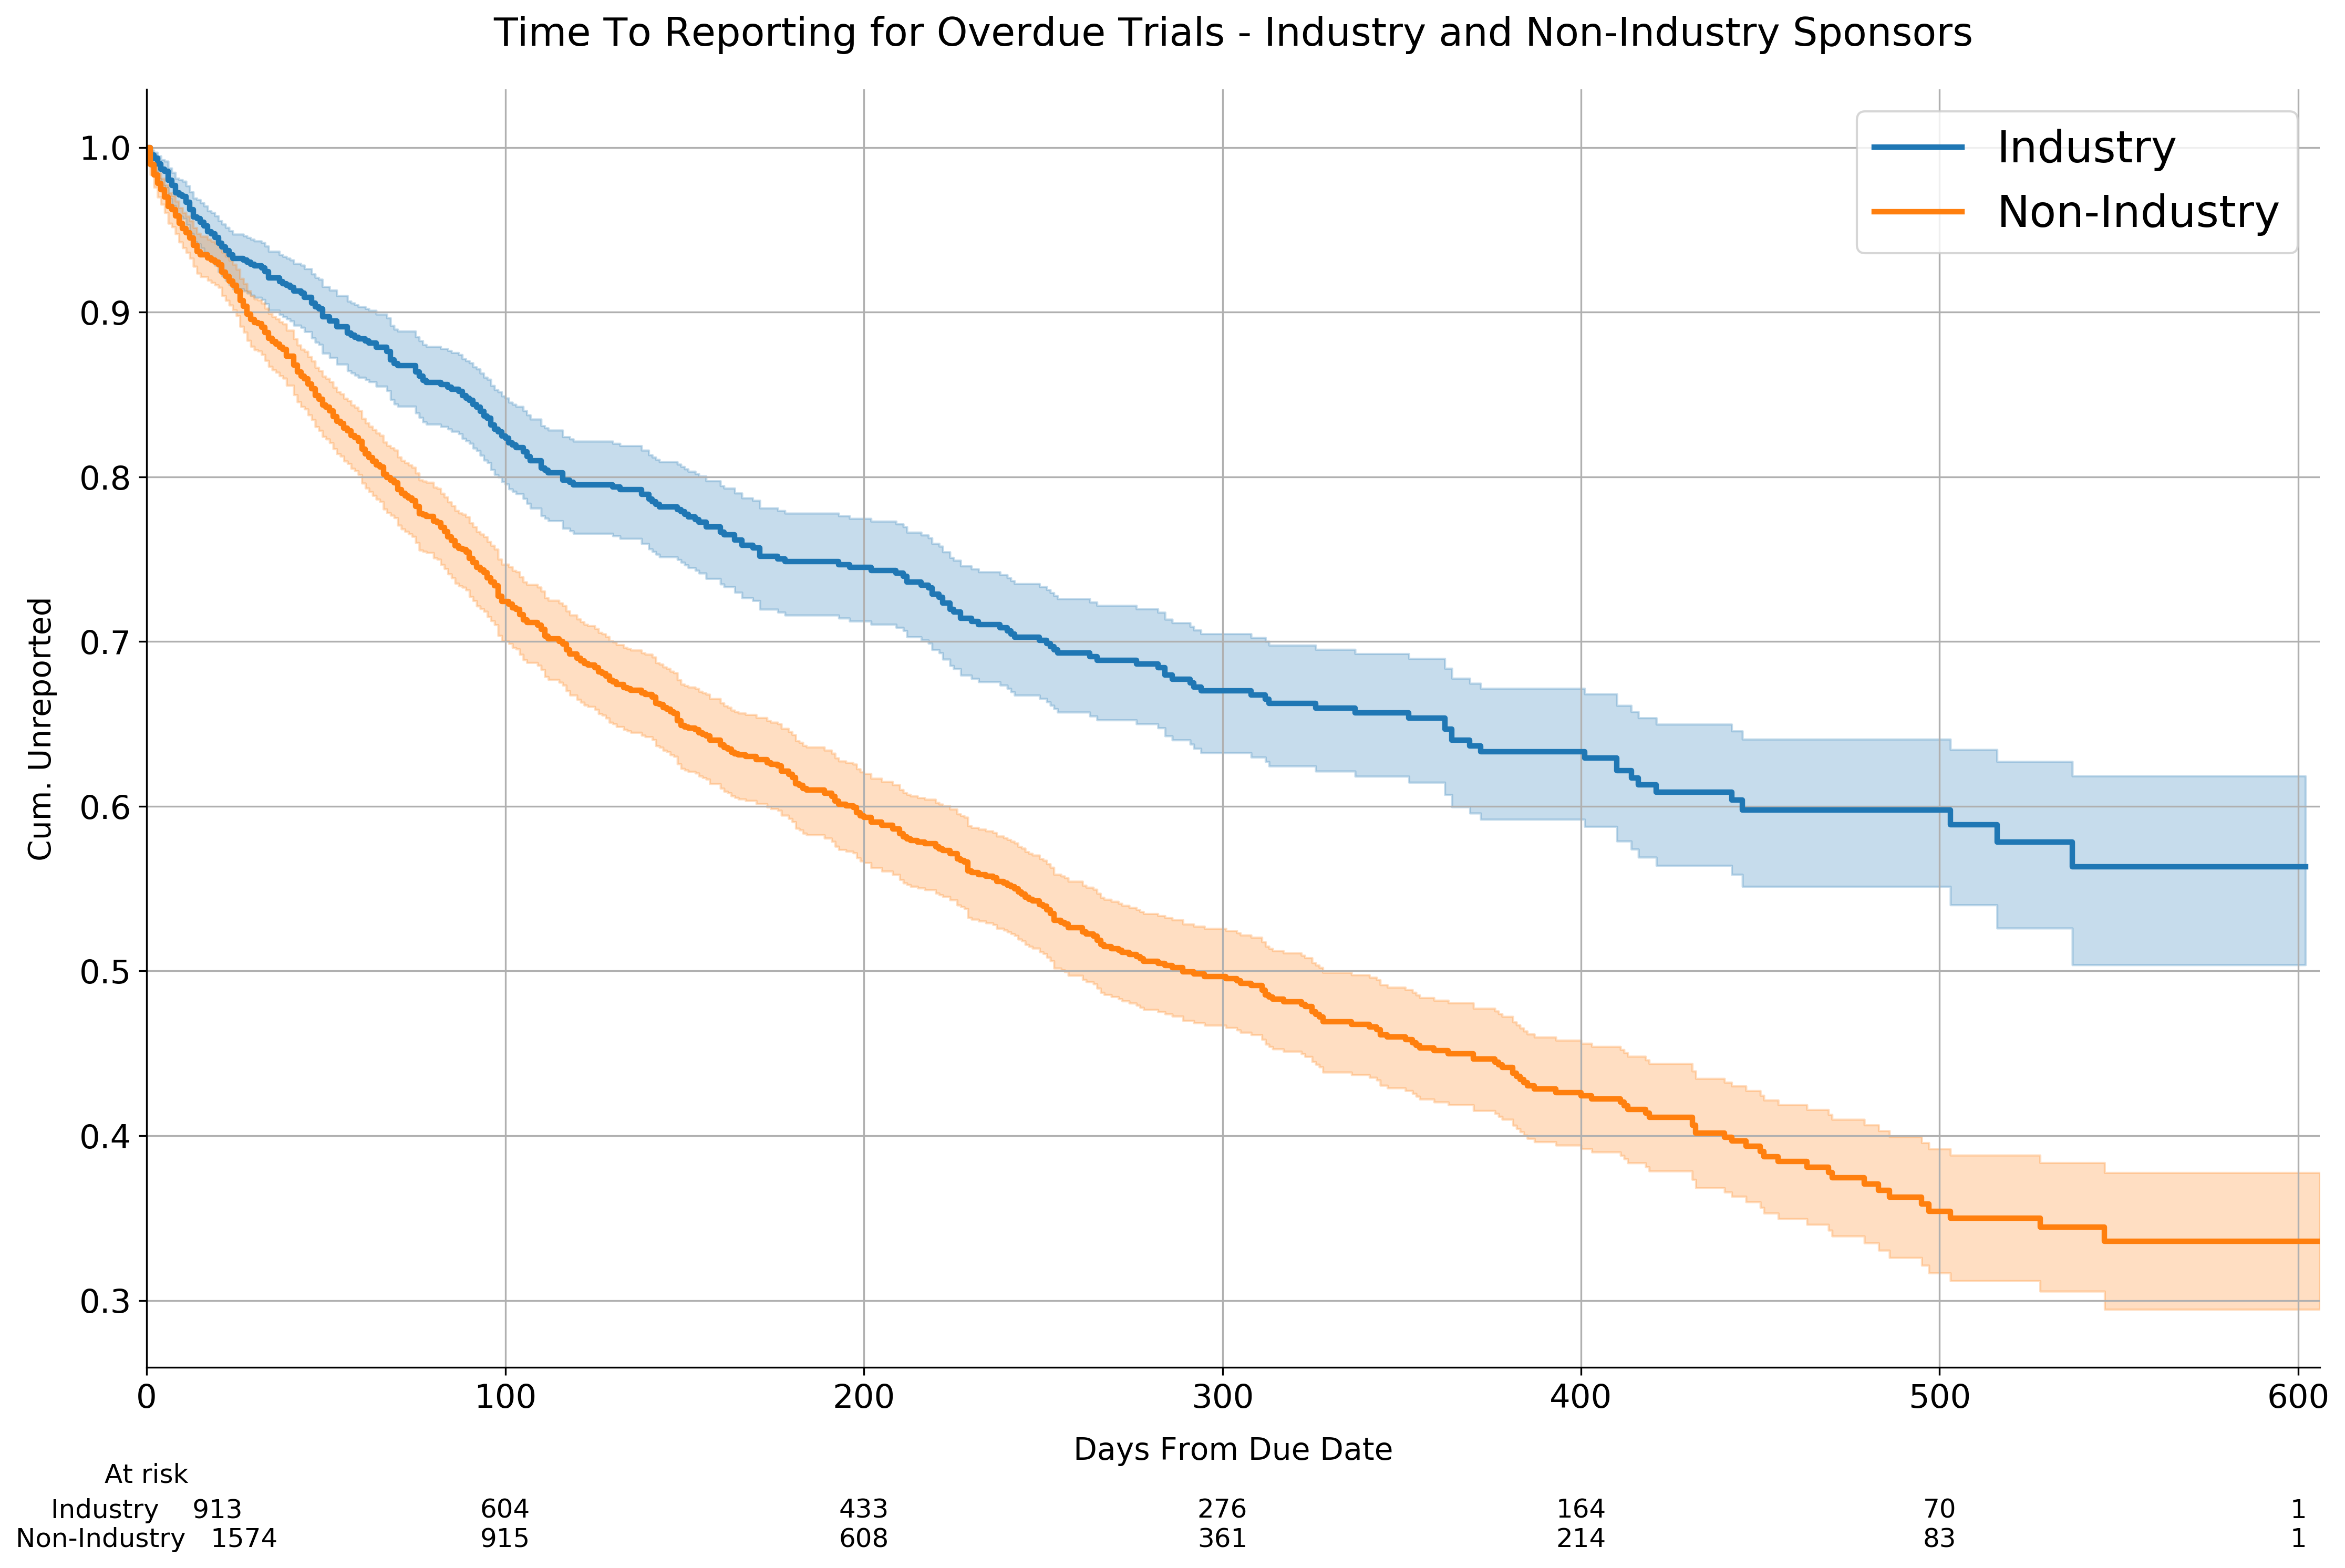

In [20]:
#KM Curve for reporting after becoming overdue and unreported for Industry and Non-Industry. 

fig = plt.figure(dpi=300)
ax = plt.subplot()

kmf_ind_due = KaplanMeierFitter()

kmf_ind_due.fit(reporting_surv_due.duration_due[reporting_surv_due.sponsor_type == 'Industry'], 
        reporting_surv_due["reported"][reporting_surv_due.sponsor_type == 'Industry'], label = 'Industry')
ax = kmf_ind_due.plot(ci_show=True, figsize=(15,10), grid=True, lw = 2.5, ax=ax)

kmf_non_ind_due = KaplanMeierFitter()
kmf_non_ind_due.fit(reporting_surv_due.duration_due[reporting_surv_due.sponsor_type != 'Industry'], 
        reporting_surv_due["reported"][reporting_surv_due.sponsor_type != 'Industry'], label = 'Non-Industry')
ax = kmf_non_ind_due.plot(ci_show=True, figsize=(15,10), grid=True, lw = 2.5, ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=15)
plt.title("Time To Reporting for Overdue Trials - Industry and Non-Industry Sponsors", pad=20, fontsize = 18)
plt.ylabel('Cum. Unreported', labelpad=10, fontsize=14)
plt.xlabel('Days From Due Date', labelpad=10, fontsize=14)
ax.legend(fontsize = 20)

print('Median time to report for Industry: {} days'.format(kmf_ind_due.median_survival_time_))
print('Median time to report for Industry: {} days'.format(kmf_non_ind_due.median_survival_time_))

add_at_risk_counts(12, kmf_ind_due, kmf_non_ind_due)

In [21]:
#Watermark for module versions
%load_ext watermark
%watermark  -v -p pandas,numpy,matplotlib,lifelines,plotly

CPython 3.7.5
IPython 7.9.0

pandas 0.25.2
numpy 1.17.3
matplotlib 3.1.1
lifelines 0.22.10
plotly 4.2.1
